In [1]:
import pymolviz as pmv
from xbpy import rdutil
import numpy as np

In [2]:
mols = rdutil.read_molecules("bromine_systematic_surface.sdf")

In [3]:
energies = []
for mol in mols:
    energies.append(mol.GetPropsAsDict()["energy"])

In [4]:
positions = []
for mol in mols:
    positions.append(rdutil.position(mol.GetAtomWithIdx(6)))

In [5]:
energies = np.array(energies)
positions = np.array(positions)

In [6]:
unique_indices = np.unique(positions, axis=0, return_index=True)[1]

In [7]:
positions = positions[unique_indices]
energies = energies[unique_indices]
filter = energies < 0

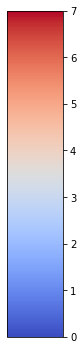

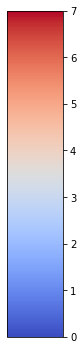

In [8]:
irregular_points = pmv.Points(positions[filter], -energies[filter], clims =(0,7), render_as_spheres=True, sphere_radius=0.03)
irregular_points.to_script().write("iterpolate_irregular_base.py")
irregular_points.get_color_map()

In [9]:
# for fixed step size
step_size = np.array([.25, .25, .25])
n = np.floor(np.min(positions, axis = 0)/step_size)
new_min = n * step_size
m = np.ceil((np.max(positions, axis = 0) - new_min)/step_size)
new_max = new_min + m * step_size
x,y,z = np.meshgrid(*[np.arange(new_min[i], new_max[i], step_size[i]) for i in range(3)])
x = x.flatten()
y = y.flatten()
z = z.flatten()
regular_positions = np.array([x,y,z]).T

new_min = np.min(positions, axis = 0)
new_max = np.max(positions, axis = 0)
spacing = np.array([0.25, 0.25, 0.25])
m = np.ceil((new_max - new_min) / spacing).astype(int)
x,y,z = np.meshgrid(*[np.linspace(new_min[i], new_max[i], m[i]) for i in range(3)])
x = x.flatten()
y = y.flatten()
z = z.flatten()
regular_positions = np.array([x,y,z]).T

## custom interpolation /w falloff

In [10]:
from scipy.spatial import KDTree

In [11]:
irregular_kdtree = KDTree(positions)
regular_kdtree = KDTree(regular_positions)

In [12]:
radius = 1
surrounding_points = regular_kdtree.query_ball_tree(irregular_kdtree, r=radius)

In [13]:
len(surrounding_points)

74088

In [14]:
len(regular_positions)

74088

In [15]:
def weighting(distances):
    return (-np.tanh((distances/0.25*4) - 2) + 1)/2

def falloff(distances):
    return (-np.tanh((distances/0.25*4) - 5) + 1)/2

def interpolate(values, positions, position):
    distances = np.linalg.norm(positions - position, axis=1)
    weights = weighting(distances)
    falloffs = falloff(distances)
    if np.sum(weights) == 0:
        return 0
    return np.sum(values * weights*falloffs)/np.sum(weights)

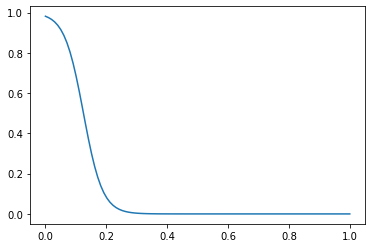

In [16]:
from matplotlib import pyplot as plt
plt.plot(np.linspace(0,1,100), weighting(np.linspace(0,1,100)))

In [17]:
custom_energies = []
for i in range(len(regular_positions)):
    filter = np.zeros(len(positions), dtype=bool)
    filter[surrounding_points[i]] = True
    custom_energies.append(interpolate(energies[filter], positions[filter], regular_positions[i]))

In [18]:
custom_energies = np.array(custom_energies)

In [19]:
np.min(custom_energies)

-12.79612126562763

In [20]:
custom_filter = custom_energies < -0.01

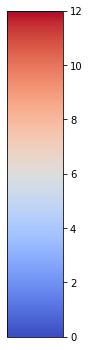

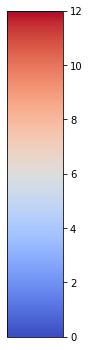

In [21]:
p = pmv.Points(regular_positions[custom_filter], -custom_energies[custom_filter], clims=(0,12), render_as_spheres=True, sphere_radius=0.1)
p.to_script(name="interpolate_custom").write("iterpolate_custom.py")
p.get_color_map()

p = pmv.Points(regular_positions[custom_filter] - min_boundary, -custom_energies[custom_filter], clims=(0,7), render_as_spheres=True, sphere_radius=0.05)
p.to_script().write("iterpolate_custom_filtered.py")
p.get_color_map()

In [22]:
import gemmi

In [23]:
custom_energies = np.clip(-custom_energies, 0, 12)

In [24]:
e = custom_energies.reshape(m.astype(np.int32)).astype(np.float32)
e = np.swapaxes(e, 0, 1)
grid = gemmi.FloatGrid(e)

In [25]:
grid.set_unit_cell(gemmi.UnitCell(*(new_max - new_min),90,90,90))

In [26]:
ccp4 = gemmi.Ccp4Map()
ccp4.grid = grid
ccp4.grid.spacegroup = gemmi.find_spacegroup_by_name("P 1")
ccp4.update_ccp4_header()
ccp4.set_header_i32(5, n[0].astype(np.int32)), ccp4.set_header_i32(6, n[1].astype(np.int32)), ccp4.set_header_i32(7, n[2].astype(np.int32))
ccp4.write_ccp4_map("custom3.ccp4")

In [27]:
# volume test_vol, custom3, 0.1 blue 0.05 6 yellow 0.005 12 red 0.1

In [29]:
values = []
eval_values = []
positions = []
for i in range(len(np.array(ccp4.grid).flatten())):
    p = ccp4.grid.index_to_point(i)
    positions.append(ccp4.grid.point_to_position(p))
    values.append((p.value))
    eval_values.append(ccp4.grid.interpolate_value(positions[-1]))

In [30]:
positions = np.array([np.array([pos.x, pos.y, pos.z]) for pos in positions])
values = np.array(values)

In [31]:
positions

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.25,  0.  ,  0.  ],
       [ 0.5 ,  0.  ,  0.  ],
       ...,
       [ 9.75, 10.25, 10.25],
       [10.  , 10.25, 10.25],
       [10.25, 10.25, 10.25]])

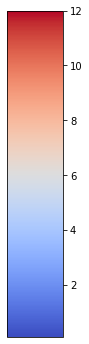

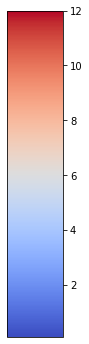

In [32]:
p = pmv.Points(positions[values > 0.1] + new_min, values[values > 0.1], render_as_spheres=True, sphere_radius=0.05)
p.to_script().write("regrid.py")
p.get_color_map()

In [33]:
min(values)

0.0

In [34]:
new_min

array([-5.25, -5.25, -5.25])

In [35]:
max(custom_energies)

12.0

In [36]:
np.min(positions, axis=0)

array([0., 0., 0.])

In [37]:
map = gemmi.read_ccp4_map("1a00_2fofc.ccp4")

In [38]:
map.header_i32(5), map.header_i32(6), map.header_i32(7)

(15, 78, -54)